In [1]:
import gc

from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

from stochman.geodesic import geodesic_minimizing_energy
from stochman import CubicSpline

from utils import *
from circular_utils import *
from plot_utils import *

In [2]:
# Parameters
num_points = 200
r_inner = 0.7  # Inner radius (hole radius)
r_outer = 1.0  # Outer radius

In [3]:
# Generate points
data = generate_annular_points(num_points, r_inner, r_outer)
data_3d = generate_annular_points_3d(num_points, r_inner, r_outer)
grid_size = 50
z_grid, x_lin, y_lin = generate_grid(grid_size=grid_size, device='cpu')

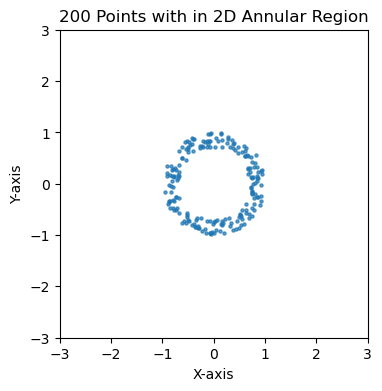

In [4]:
simple_2d_plot(data, num_points)

In [5]:
dm = DensityMetric(data, 0.1)
#dm_energy = lambda _model, _curve: _model.curve_energy(_curve.points())

In [6]:
real_bg = dm.density(z_grid.reshape(-1, 2)).reshape((grid_size, grid_size))
real_bg.shape

torch.Size([50, 50])

In [7]:
num_curves = 30
N, D = data.shape
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2

In [8]:
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=250)

tensor(False)

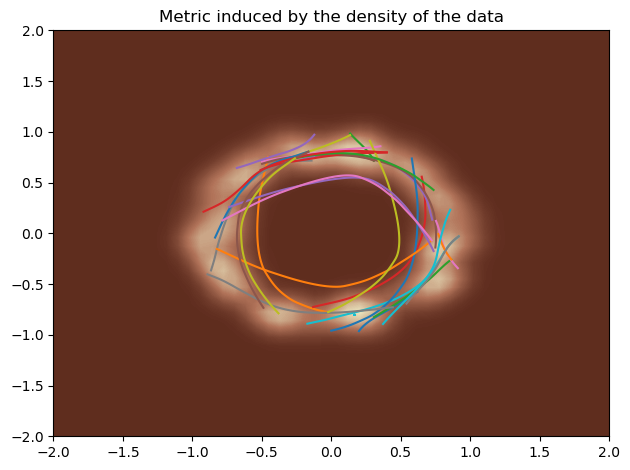

In [9]:
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
#plt.contourf(x_lin, y_lin, real_bg, levels=100, cmap='pink')  # Use the custom brownish colormap
plt.contourf(x_lin, y_lin, real_bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
batch_c.plot()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("Metric induced by the density of the data")
plt.tight_layout()
plt.show()

In [10]:
batch_c.euclidean_length().mean().item()

1.2073251008987427

In [11]:
data_vae = embed_points_2d_to_100d(data)
train_loader = torch.utils.data.DataLoader(DumbDataset(z=data,y=data_vae), batch_size=64, shuffle=True)
data_vae.shape, data_vae.max(), data_vae.min()

((200, 100), 0.98775905, -0.98897356)

In [12]:
# normalize the data_vae and compute PCA
n_data_vae = (data_vae - data_vae.mean(axis=0)) / data_vae.std(axis=0)
data_vae_3d = PCA(n_components=3).fit_transform(n_data_vae)
# normalize the data_vae_3d
data_vae_3d = (data_vae_3d - data_vae_3d.mean(axis=0)) / data_vae_3d.std(axis=0)

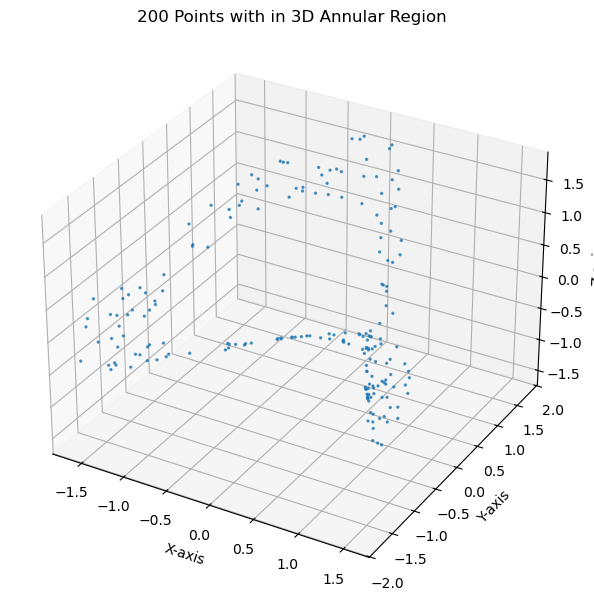

In [13]:
simple_3d_plot(data_vae_3d, num_points)
#interactive_3d_plot(data_vae_3d, num_points)

In [14]:
model = get_decoder()
model.train();

In [15]:
epochs = 40
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
# write a training loop with tqdm
model.to(device)
losses = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        opt.zero_grad()
        y_hat = model(z)
        loss = torch.nn.functional.mse_loss(y_hat, y.to(device))
        losses.append(loss.item())
        loss.backward()
        opt.step()

100%|██████████| 40/40 [00:00<00:00, 71.81it/s]


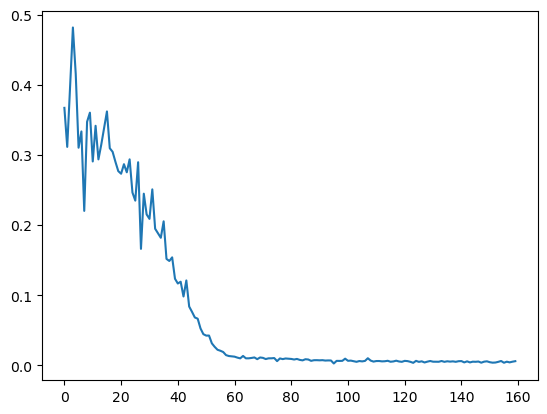

In [17]:
# plot the losses
plt.plot(losses)
plt.show()

In [18]:
## Put trained models in 'eval' mode
model.eval();
model.to('cpu');

In [29]:
gc.collect()

1091

In [20]:
z_grid_list = z_grid.reshape(-1, 2)

In [22]:
# compute the jacoian of the model with respect to the data
# Generate input data
#z_grid = torch.FloatTensor(np.random.uniform(-2, 2, size=(1000, 2))).to(device)
with torch.no_grad():
    y_hat_grid_list = model(z_grid_list)

NameError: name 'z_grid_list' is not defined

In [37]:
jj = vmap(jacfwd(model))(z_grid_list[:2])

In [38]:
jj.shape

torch.Size([2, 100, 2])

In [90]:
# loop through the grid and compute the jacobian
bg = []

for point in tqdm(z_grid_list):
    J = torch.autograd.functional.jacobian(model, point.unsqueeze(0)).squeeze(0).squeeze(1)
    bg.append(torch.sqrt(torch.det((J.T @ J).cpu())).item())
bg = np.array(bg).reshape((grid_size, grid_size))

100%|██████████| 10000/10000 [00:51<00:00, 192.57it/s]


In [39]:
from torch.func import jacrev, jacfwd, vmap

from stochman.manifold import EmbeddedManifold


class DecoderInducedManifold(EmbeddedManifold):
    def __init__(self, decoder):
        self.decoder = decoder 
    
    def embed(self, c, jacobian = False):
        output_dim = c.shape[1]
        batch_size = c.shape[0]
        if jacobian:
            return self.decoder(c), vmap(jacfwd(self.decoder))(c)
        else:
            return self.decoder(c)

In [52]:
M = DecoderInducedManifold(model)
vol_by_dec = M.volume(z_grid_list).detach().numpy().reshape((grid_size, grid_size))
c, _ = M.connecting_geodesic(p0=data[curve_indices[:, 0]], p1=data[curve_indices[:, 1]])

(50, 50)

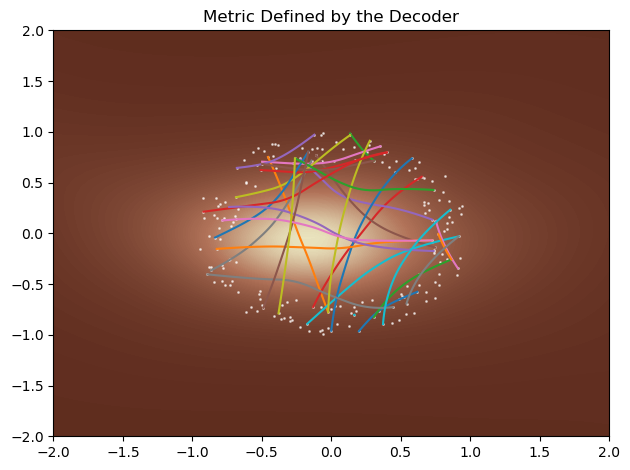

In [55]:
# Plot the magnification factor
plt.figure()
plt.contourf(x_lin, y_lin, vol_by_dec, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
c.plot()
plt.title("Metric Defined by the Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

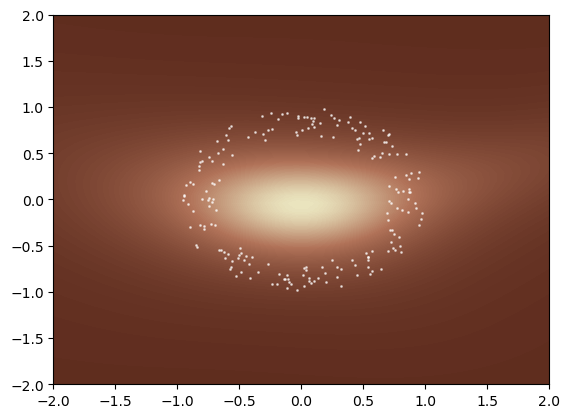

In [35]:
plt.contourf(x_lin, y_lin, bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 0]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=200)
batch_c.plot()
plt.show()